**Exercise 4.2** NetworkX provides a function called `powerlaw_cluster_graph` that implements the "Holme and Kim algorithm for growing graphs with powerlaw degree distribution and approximate average clustering". See if you can use it to generate a graph that has the same number of nodes as the Facebook dataset, the same average degree, and the same clustering coefficient. How does the degree distribution in the model compare to the acutal distribution?

In [23]:
%matplotlib inline

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import seaborn as sns

#from utils import decorate

# I set the random seed so the notebook 
# produces the same results every time.
np.random.seed(17)

# TODO: remove this when NetworkX is fixed
from warnings import simplefilter
import matplotlib.cbook
simplefilter("ignore", matplotlib.cbook.mplDeprecation)

We use the `read_graph` function to import the Facebook data:

In [24]:
def read_graph(filename):
    G = nx.Graph()
    array = np.loadtxt(filename, dtype=int)
    G.add_edges_from(array)
    return G

fb = read_graph('https://snap.stanford.edu/data/facebook_combined.txt.gz')
fb_n = len(fb)
fb_m = len(fb.edges())
fb_k = int(round(fb_m/fb_n))
fb_n, fb_m, fb_k

(4039, 88234, 22)

The functions we need to compute the clustering coefficient and the degree are as follows:

In [25]:
def degrees(G):
    return [G.degree(u) for u in G]

fb_deg = degrees(fb)

def clustering_coefficient(G):
    def node_clustering(G, u):
        def all_pairs(nodes):
            for i, u in enumerate(nodes):
                for j, v in enumerate(nodes):
                    if i > j:
                        yield u, v
        neighbors = G[u]
        k = len(neighbors)
        if k < 2:
            return np.nan
        possible = k*(k-1)/2
        exist = 0
        for v, w, in all_pairs(neighbors):
            if G.has_edge(v, w):
                exist+=1
        return exist/possible

    cu = [node_clustering(G, node) for node in G]
    return np.nanmean(cu)

The Facebook dataset has the following graph characteristics:

In [26]:
print ("FB dataset # of nodes: ", fb_n)
print ("FB dataset average degree: ", np.mean(fb_deg))
print ("FB dataset clustering coefficient: ", clustering_coefficient(fb))

FB dataset # of nodes:  4039
FB dataset average degree:  43.69101262688784
FB dataset clustering coefficient:  0.6170038336292958


The Holm and Kim algorithm function has the following documentation:

nx.generators.random_graphs.powerlaw_cluster_graph(n, m, p, seed = None)

where the parameters are:

**n** (int) - the number of nodes

**m** (int) - the number of random edges to add for each new node

**p** (float) - probability of adding a triangle after adding a random edge

**seed** (int, random_state, or None) - indicator of random number generation state

From these parameters, we then use the Holm and Kim algorithm to generate a graph.

In [27]:
hk = nx.generators.random_graphs.powerlaw_cluster_graph(fb_n, fb_k, 0.8, seed = 11)

hk_n = len(hk)
hk_m = len(hk.edges())
hk_k = int(round(hk_m/hk_n))
hk_deg = degrees(hk)

In [28]:
print ("HK # of nodes: ", hk_n)
print ("HK # of edges: ", hk_m)
print ("HK average degree: ", np.mean(hk_deg))
print ("HK degree std: ", np.std(hk_deg))
print ("HK clustering coefficient: ", clustering_coefficient(hk))

HK # of nodes:  4039
HK # of edges:  88110
HK average degree:  43.62961128992325
HK degree std:  44.09030408387874
HK clustering coefficient:  0.09845855975864194


The number of nodes and the degree is very close to that of the Facebook dataset. The degree standard deviation is lower and the clustering coefficient is much smaller.

We can loop through `p` to see how it affects the average clustering coefficient of the graph.

In [29]:
p_ = np.array(range(11))/10
p_

hk_cc = []

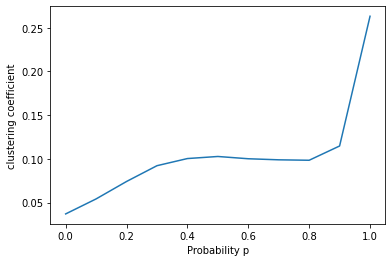

In [30]:
for p in p_:
    hk_cc.append(clustering_coefficient(nx.generators.random_graphs.powerlaw_cluster_graph(hk_n, hk_k, p, seed = 11)))

plt.plot(p_, hk_cc, label = "clustering coefficient of Holm-Kim algorithm")
plt.xlabel("Probability p")
plt.ylabel("clustering coefficient")
plt.show()


The clustering coefficient increases rapidly as `p` approaches 1, but is still much smaller than the clustering coefficient for the Facebook dataset of around 0.6.

We can compare the degree distributions of hk to the Facebook dataset using the Pmf.

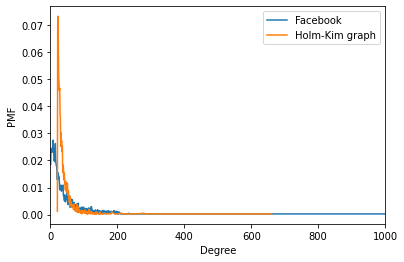

In [31]:
from empiricaldist import Pmf

pmf_fb = Pmf.from_seq(fb_deg)
pmf_hk = Pmf.from_seq(hk_deg)

pmf_fb.plot(label='Facebook', color='C0')
pmf_hk.plot(label='Holm-Kim graph', color='C1')
plt.xlabel("Degree")
plt.ylabel("PMF")
plt.xlim([0, 1000])
plt.legend()

The model PMF peak is much higher than that of the FB PMF and is also offset.

We can then compare the CDFs of the model to the Facebook dataset.

Text(0, 0.5, 'CDF')

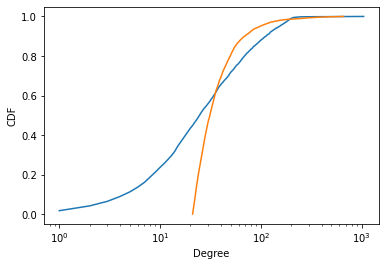

In [33]:
from empiricaldist import Cdf

cdf_fb = Cdf.from_seq(fb_deg)
cdf_hk = Cdf.from_seq(hk_deg)

cdf_fb.plot(label = 'Facebook', color = 'C0')
cdf_hk.plot(label = 'Holm-Kim', color = 'C1')
plt.xscale('log')
plt.xlabel('Degree')
plt.ylabel('CDF')

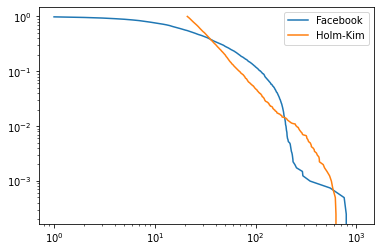

In [34]:
comp_cdf_fb = 1-cdf_fb
comp_cdf_hk = 1-cdf_hk

comp_cdf_fb.plot(label = 'Facebook', color = 'C0')
comp_cdf_hk.plot(label = 'Holm-Kim', color = 'C1')
plt.xscale('log')
plt.yscale('log')
plt.legend()

In [ ]:
Although noisy, the Holm-Kim algorithm approximates well the heavy-tail behavior of the Facebook dataset.